In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shelve
import numpy as np
from copy import deepcopy
from scipy.fft import rfft, rfftfreq
import numpy as np

def logit_normalise(df, cols, order=1):
    for c in cols:
        df[c + "[pu]"] = df[c] / (df[c].max() + 0.001)
        df[c + "-LNT"] = np.log(df[c + "[pu]"]**order /
                                (1 - df[c + "[pu]"]**order))
    return df

def make_rfft(data, sample_rate=500.5005):
    yf = rfft(data)
    xf = rfftfreq(len(data), 1 / sample_rate)
    return xf, np.abs(yf)

# SOLETE: 
1. Resolution: 1sec, 1min, 5min, 60min
2. Features: ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]', 'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'P_Solar[kW]', 'Pressure[mbar]', 'Azimuth[deg]', 'Elevation[deg]']


In [ ]:
resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
# resolutions = {
#     1: "SOLETE_Pombo_1sec.h5",
#     60: "SOLETE_Pombo_1min.h5",
#     300: "SOLETE_Pombo_5min.h5",
#     3600: "SOLETE_Pombo_60min.h5"
# }
pth = "SOLETE_data"

# Solar
# cols = ['TEMPERATURE[degC]', 'POA Irr[kW1m2]', 'P_Solar[kW]']

# Wind
# cols = ['WIND_SPEED[m1s]', 'P_Gaia[kW]', 'WIND_DIR[deg]']

cols = ['WIND_SPEED[m1s]', 'TEMPERATURE[degC]']

# fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
for i, r in enumerate(resolutions):
    print(r)
    df = pd.read_hdf(os.path.join(pth, resolutions[r]))
    df = df.sort_index()
    # df = df["2018-09-01":"2018-10-30"]
    # df[cols].plot(ax=axs[i], secondary_y=cols[-1]/)
    resolutions[r] = df
# fig.tight_layout()

In [ ]:
def three_sigma(Ser1):
    '''
    3 sigma standard
    '''
    rule = (Ser1.mean() - 3 * Ser1.std() >
            Ser1) | (Ser1.mean() + 3 * Ser1.std() < Ser1)
    index = Ser1[rule].index
    return index


# cols = ['WIND_SPEED[m1s]', 'TEMPERATURE[degC]']
resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
pth = "SOLETE_data"
cols = ['TEMPERATURE[degC]']
# cols = ['WIND_SPEED[m1s]', 'TEMPERATURE[degC]', 'WIND_DIR[deg]','P_Gaia[kW]']
fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
for i, r in enumerate(resolutions):
    # df = resolutions[r]
    df = pd.read_csv(os.path.join(pth, resolutions[r]),
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)
    # 1-diff
    df_delta_pos = (df - df.shift(1))[cols].dropna()
    df_delta_neg = (df.shift(-1) - df)[cols].dropna()
    for c in cols:
        outlier_idx_pos = three_sigma(df_delta_pos[c])
        outlier_idx_neg = three_sigma(df_delta_neg[c])
        outlier_idx = outlier_idx_pos.intersection(outlier_idx_neg)
        # df[c].plot(ax=axs[i])
        df.loc[outlier_idx_neg, c] = np.nan
        df[c] = df[c].interpolate(limit_direction='both', kind='quadratic')

    # axs[i].scatter(outlier_idx, df_delta_pos.loc[outlier_idx, cols[0]])
    # axs[i].plot(df_delta_pos.loc[:, cols[0]])
    # axs[i].plot(df_delta_pos.loc[:, cols[0]].index, np.repeat(df_delta_pos.loc[:, cols[0]].mean()- df_delta_pos.loc[:, cols[0]].std()*3, len(df_delta_pos)) )
    # axs[i].plot(df_delta_pos.loc[:, cols[0]].index, np.repeat(df_delta_pos.loc[:, cols[0]].mean()+ df_delta_pos.loc[:, cols[0]].std()*3, len(df_delta_pos)) )

    # df.to_csv(os.path.join(pth, "new_"+resolutions[r]))
    resolutions[r] = df
fig.tight_layout()


In [ ]:
# fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
names = [
    "SOLETE_clean_1sec.csv",
    "SOLETE_clean_1min.csv",
    "SOLETE_clean_5min.csv",
    "SOLETE_clean_60min.csv",
]
for i, r in enumerate(resolutions):
    print(r)
    df = resolutions[r]
    df["MATH_DIR[deg]"] = 270 - df["WIND_DIR[deg]"]
    df["u"] = df["WIND_SPEED[m1s]"] * np.cos(
        df["MATH_DIR[deg]"] * np.pi / 180.0)
    df["v"] = df["WIND_SPEED[m1s]"] * np.sin(
        df["MATH_DIR[deg]"] * np.pi / 180.0)
    df.to_csv(os.path.join(pth, names[i]))

Normalization

In [ ]:
from datasets.Functions import import_PV_WT_data, PV_Performance_Model

resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
pth = "datasets"
cols = ['u', 'v', 'P_Gaia[kW]']
v = 1
# cols = ['TEMPERATURE[degC]','POA Irr[kW1m2]','P_Solar[kW]']
info = import_PV_WT_data()
# fig, axs = plt.subplots(len(resolutions), figsize=[20, 15])
for i, r in enumerate(resolutions):

    # Skip 1sec, too large
    if i == 0 or i == 1:
        continue

    df = pd.read_csv(os.path.join(pth, resolutions[r]),
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)
    df = df['2018-08':'2019-05']
    print(len(df[df["P_Gaia[kW]"] <= 0.0]))

    # Normalise the data
    df['Pac'], df['Pdc'], df['TempModule'], df[
        'TempCell'] = PV_Performance_Model(df, info[0])
    df['P_Solar[kW]'] = np.where(df['Pac'] >= 1.5 * df['P_Solar[kW]'],
                                 df['Pac'], df['P_Solar[kW]'])
    df['P_Gaia[kW]'] = np.where(df['P_Gaia[kW]'] <= 0.0, 0.001,
                                df['P_Gaia[kW]'])
    df['P_Sythetic[kW]'] = np.where(df['P_Sythetic[kW]'] <= 0.0, 0.001,
                                    df['P_Sythetic[kW]'])
    df = logit_normalise(df,
                         cols=['P_Gaia[kW]', 'P_Sythetic[kW]', 'P_Solar[kW]'])
    # print(df.columns.tolist())
    # # df['P_Gaia_GLNT[pu]'] = 1 / np.sqrt(2 * np.pi) * v / (
    # #     df['P_Gaia[pu]'] *
    # #     (1 - df['P_Gaia[pu]']**v)) * np.exp(-0.5 * df['P_Gaia_LNT[pu]']**2)
    # # df['P_Solar_GLNT[pu]'] = 1 / np.sqrt(2 * np.pi) * v / (
    # #     df['P_Solar[pu]'] *
    # #     (1 - df['P_Solar[pu]']**v)) * np.exp(-0.5 * df['P_Solar_LNT[pu]']**2)

    # df.to_csv(os.path.join(pth, resolutions[r]))
    df.plot(y=['P_Sythetic[kW]'], kind="hist", bins=50)
    df.plot(y=['P_Sythetic[kW]-LNT'], kind="hist", bins=50)
    df.plot(y=['P_Gaia[kW]'], kind="hist", bins=50)
    df.plot(y=['P_Gaia[kW]-LNT'], kind="hist", bins=50)
    # resolutions[r] = df
    # break
    # df[cols].plot(ax=axs[i], secondary_y=cols[-1])
# fig.tight_layout()


Make synthetic wind power data

In [ ]:
R_d = 287.058
R_v = 461.495
R = info[1]["D"] / 2
cin = info[1]["Cin"]
cout = info[1]["Cout"]
print(R)


def make_synthetic_wind_power(df):
    p_1 = 6.1078 * np.power(
        10, 7.5 * df["TEMPERATURE[degC]"] / (df["TEMPERATURE[degC]"] + 237.3))
    p_v = p_1 * df["HUMIDITY[%]"]
    p_d = df["Pressure[mbar]"] * 100 - p_v
    print(df["Pressure[mbar]"].max())
    print(df["Pressure[mbar]"].min())
    air_density = p_d / (R_d * (df["TEMPERATURE[degC]"] + 273.15)) + p_v / (
        R_v * (df["TEMPERATURE[degC]"] + 273.15))
    print(air_density.max())
    print(air_density.min())
    # ws = np.where(df["WIND_SPEED[m1s]"])
    synthetic_wind = 0.5 * np.pi * R**2 * df[
        "WIND_SPEED[m1s]"]**3 * air_density * 0.001
    synthetic_wind = np.where(df["WIND_SPEED[m1s]"] < cin, 0, synthetic_wind)
    synthetic_wind = np.where(df["WIND_SPEED[m1s]"] > cout, 0, synthetic_wind)
    return synthetic_wind


resolutions = {
    1: "SOLETE_clean_1sec.csv",
    60: "SOLETE_clean_1min.csv",
    300: "SOLETE_clean_5min.csv",
    3600: "SOLETE_clean_60min.csv"
}
for i, r in enumerate(resolutions):
    # Skip 1sec, too large
    if i == 0:
        continue
    df = pd.read_csv(resolutions[r],
                     index_col=0,
                     parse_dates=True,
                     infer_datetime_format=True)
    # df = resolutions[r]
    # p_1 = 6.1078 * np.power(
    #     10, 7.5 * df["TEMPERATURE[degC]"] / (df["TEMPERATURE[degC]"] + 237.3))
    # p_v = p_1 * df["HUMIDITY[%]"]
    # p_d = df["Pressure[mbar]"] * 100 - p_v
    # print(df["Pressure[mbar]"].max())
    # print(df["Pressure[mbar]"].min())
    # air_density = p_d / (R_d * (df["TEMPERATURE[degC]"] + 273.15)) + p_v / (
    #     R_v * (df["TEMPERATURE[degC]"] + 273.15))
    # print(air_density.max())
    # print(air_density.min())
    # # ws = np.where(df["WIND_SPEED[m1s]"])
    # synthetic_wind = 0.5 * np.pi * R**2 * df["WIND_SPEED[m1s]"]**3 * air_density * 0.001
    # synthetic_wind = np.where(synthetic_wind < cin, synthetic_wind*0.67, synthetic_wind)
    df["P_Sythetic(kW)"] = make_synthetic_wind_power(df)
    print(df.columns.tolist())
    df.to_csv(resolutions[r])
    resolutions[r] = df
    # df['2018-08':'2019-05'].plot(x="P_Sythetic(kW)",y="P_Gaia[kW]", kind="scatter")

    # break


simple plot

In [7]:
df = pd.read_csv("datasets/SOLETE_clean_5min.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)
df = df['2018-08-13':'2018-08-16']
df.plot(y=["P_Solar[kW]"])


/tmp/ipykernel_3121404/297976849.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("datasets/SOLETE_clean_5min.csv",


FileNotFoundError: [Errno 2] No such file or directory: 'datasets/SOLETE_clean_5min.csv'

Freq domain

In [ ]:
# df = pd.read_csv("datasets/SOLETE_clean_1min.csv")["P_Gaia[kW]"].values.flatten()
df = pd.read_csv(
    "datasets/SOLETE_clean_1min.csv")["P_Solar[kW]"].values.flatten()

# Number of sample points
N = len(df)
# sample spacing
T = 1 / 60 / 24
x = np.linspace(0.0, N * T, N, endpoint=False)
y = df
yf = fft(y)
xf = fftfreq(N, T)[:N // 160]
import matplotlib.pyplot as plt

plt.plot(xf, 2.0 / N * np.abs(yf[0:N // 160]))
plt.grid()
plt.show()

Windspeed-Power curve

In [ ]:
from datasets.Functions import import_PV_WT_data
from scipy.interpolate import CubicSpline


def logit_normalise(df, cols, order=1):
    for c in cols:
        df[c] = np.where(df[c] <= 0, 0.001, df[c])
        df[c + "[pu]"] = df[c] / (df[c].max() + 0.001)
        df[c + "-LNT"] = np.log(df[c + "[pu]"]**order /
                                (1 - df[c + "[pu]"]**order))
    return df

def inverse_logit_transform(data, order=1):
    out = (1 + 1 / np.exp(data)) ** (-1/order)
    # out = np.power(out, -1 / order)
    return out
res = "5min"
df = pd.read_csv(f"datasets/SOLETE_clean_{res}.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)

tem = 270 - df["WIND_DIR[deg]"]
df["u"] = np.cos(tem / 180 * np.pi)
df["v"] = np.sin(tem / 180 * np.pi)
_, WT = import_PV_WT_data()
ws = np.array([0.0, 1.0, 2.0] + WT["CWs"])
wp = np.array([0.0, 0.0, 0.0] + WT["CP"])

# fig,ax=plt.subplots()
# ax.scatter(df["WIND_SPEED[m1s]"],df["P_Gaia[kW]"], alpha=0.05, label="measured")
# ax.plot(ws,wp,c="C1", label="given")
# ax.set_xlabel("wind speed")
# ax.set_ylabel("wind power")
# ax.legend()


cs = CubicSpline(ws, wp)
# cs = lambda x: np.interp(x,WT["CWs"], WT["CP"])
y = cs(df["WIND_SPEED[m1s]"])
y = np.where(y < 0, 0.001, y)
df["P_synthetic[kW]"] = y
df = logit_normalise(
    df,
    cols=["P_Gaia[kW]", "P_synthetic[kW]", "P_Solar[kW]"],
    order=1)

inverse_wind = inverse_logit_transform(df["P_Gaia[kW]-LNT"])
plt.scatter(inverse_wind, df["P_Gaia[kW][pu]"])



# idx = slice(2000, 6000)
# cols = [
#     "P_synthetic[kW]", "P_synthetic[kW]-LNT", "P_Gaia[kW]", "P_Gaia[kW]-LNT"
# ]
# fig, axs = plt.subplots(len(cols), sharex=True, figsize=[12, 8])
# for i, c in enumerate(cols):
#     axs[i].plot((df.index[idx]), df[c].values[idx])
#     axs[i].set(title=c)
# fig.tight_layout()

# cols = ["WIND_SPEED[m1s]", "WIND_DIR[deg]", "u", "v"]
# # cols = ["WIND_SPEED[m1s]", "WIND_SPEED[m1s]-LNT", "u", "u-LNT", "v", "v-LNT", "WIND_DIR[deg]"]
# fig, axs = plt.subplots(len(cols), sharex=True, figsize=[12, 10])
# for i, c in enumerate(cols):
#     axs[i].plot(df.index[idx], df[c].values[idx])
#     axs[i].set(title=c)
# fig.tight_layout()

# df.to_csv(f"datasets/SOLETE_new_{res}.csv")

ACF, PACF, Hist

In [ ]:
res = "5min"
df = pd.read_csv(f"datasets/SOLETE_new_{res}.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)
df = df['2018-08':'2019-05']
cols = [
    "P_synthetic[kW]", "P_synthetic[kW]-LNT", "P_Gaia[kW]", "P_Gaia[kW]-LNT"
]
fig, axs = plt.subplots(len(cols)//2, 2)
axs = axs.ravel()
for i in range(len(axs)):
    axs[i].hist(df[cols[i]], bins='auto')
    axs[i].set(title=cols[i])
    axs[i].autoscale(enable=True)
fig.tight_layout()

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

cols = [
    "P_synthetic[kW]", "P_Gaia[kW]"
]
fig, axs = plt.subplots(len(cols), 2)
# axs = axs.ravel()
for i in range(len(cols)):
    # axs[i].hist(df[cols[i]], bins='auto')
    # axs[i].set(title=cols[i])
    # axs[i].autoscale(enable=True)
    plot_acf(df[cols[i]], ax=axs[i, 0], auto_ylims=True, title=cols[i]+"-ACF")
    plot_pacf(df[cols[i]], ax=axs[i, 1], auto_ylims=True, title=cols[i]+"-ACF")

fig.tight_layout()


Detrend with low-resolution data

In [ ]:
feature = ["P_Gaia[kW]"]
# feature = ["P_Solar[kW]"]
df_5min = pd.read_csv("datasets/SOLETE_new_5min.csv",
                 index_col=0,
                 parse_dates=True,
                 infer_datetime_format=True)[feature]
print(df_5min)
# df_1hr_real = pd.read_csv("datasets/SOLETE_new_60min.csv",
#                  index_col=0,
#                  parse_dates=True,
#                  infer_datetime_format=True)[feature]
df_1hr = df_5min.resample('10min').mean()
print(df_1hr)
df_1hr = df_1hr.resample('5min').mean()
print(df_1hr)
df_1hr = df_1hr.interpolate()
print(df_1hr)

res = df_5min - df_1hr
print(res)
df_res = res.resample('30min').mean()
print(df_res)
df_res = df_res.resample('5min').mean()
print(df_res)
df_res = df_res.interpolate()
print(df_res)

# df_10min = df_5min.resample('30min').mean()
# df_10min = df_10min.resample('5min').mean()
# df_10min = df_10min.interpolate()

# fig, ax = plt.subplots()
# ax.plot(df_5min["2018-06-17":"2018-06-20"],label="5min")
# # ax.plot(df_1hr["2018-06-17":"2018-06-20"],label="1hr")
# # ax.plot(df_1hr_real["2018-06-16":"2018-06-30"],label="1hr-real")
# ax.plot(df_5min["2018-06-17":"2018-06-20"]-df_1hr["2018-06-17":"2018-06-20"],label="res",c="grey",alpha=0.2)
# ax.plot(df_res["2018-06-17":"2018-06-20"],label="res-30min",alpha=0.2, c="C2")
# ax.plot(df_res["2018-06-17":"2018-06-20"] + df_1hr["2018-06-17":"2018-06-20"],label="concat-30min")
# # ax.plot(df_5min["2018-06-17":"2018-06-20"] - df_res["2018-06-17":"2018-06-20"] - df_1hr["2018-06-17":"2018-06-20"],label="res-30min", alpha=0.2)
# # ax.plot(df_10min["2018-06-17":"2018-06-20"],label="real-10min")
# ax.legend()
# fig.tight_layout()

# NREL data

In [1]:
df_power = pd.read_csv("datasets/wtk_power.csv", parse_dates=True, infer_datetime_format=True)
df_wind = pd.read_csv("datasets/wtk_wind.csv", parse_dates=True, infer_datetime_format=True)
df_power["datetime"] = pd.date_range(start="2012-07-01 00:00:00", end="2013-01-01 00:00:00", freq="5min")
df_wind["datetime"] = pd.date_range(start="2012-07-01 00:00:00", end="2013-01-01 00:00:00", freq="5min")
df_power = df_power.set_index("datetime")
df_power[df_power<=0] = 0.001
df_wind = df_wind.set_index("datetime")
site_ids = df_power.columns.tolist()
df_power.describe()

NameError: name 'pd' is not defined

In [ ]:
fig, axs = plt.subplots()
# axs = axs.flatten()
df_power = logit_normalise(df_power, cols = df_power.columns)
for i in range(1):
    # axs[i].hist(df_power[site_ids[i]+"-LNT"], bins="auto")
    # df_power.drop(columns=[site_ids[i]], inplace=True)
    # axs[i].plot(df_wind.iloc[:,i])
    axs.plot(df_power.iloc[:3000,i])
    # axs[i].scatter(df_wind.iloc[:,i], df_power.iloc[:,i])
fig.tight_layout()

In [ ]:
df_power = pd.read_csv("datasets/wtk_power.csv",
                           parse_dates=True,
                           infer_datetime_format=True,
                           index_col=0).values
print(df_power)
# df_power = df_power[:24*12*2]
N = len(df_power)
SAMPLE_RATE = 1/300 * 2 * np.pi
fig, axs = plt.subplots(4,5,figsize=[5*5, 4*4])
axs = axs.flatten()
for i in range(20):
    yf = rfft(df_power[:,i].flatten())
    xf = rfftfreq(N, 1/SAMPLE_RATE)
    axs[i].plot(xf, yf)
fig.tight_layout()


In [ ]:
df_power.describe()
df_power.to_csv("datasets/NREL_power.csv")

# ZENDO

In [4]:
import pandas as pd
df = pd.read_csv("datasets/zenondo_4second.csv", index_col=0, parse_dates=True)
df.index = pd.date_range(start="2019-08-01", freq="4s", periods=len(df))
print(df.index)
df = df.resample("1min").mean()
# df = df["2019-09-01":"2019-09-07"]
# df.plot()
# df["date"] = pd.date_range("2000-01-01", freq="4s", periods=len(df))
# df = df.set_index("date", drop=True)
# df[df<=0] = 0.001
# df.columns = ["power"]
df.to_csv("datasets/zenondo_1min.csv")

DatetimeIndex(['2019-08-01 00:00:00', '2019-08-01 00:00:04',
               '2019-08-01 00:00:08', '2019-08-01 00:00:12',
               '2019-08-01 00:00:16', '2019-08-01 00:00:20',
               '2019-08-01 00:00:24', '2019-08-01 00:00:28',
               '2019-08-01 00:00:32', '2019-08-01 00:00:36',
               ...
               '2020-07-08 11:02:28', '2020-07-08 11:02:32',
               '2020-07-08 11:02:36', '2020-07-08 11:02:40',
               '2020-07-08 11:02:44', '2020-07-08 11:02:48',
               '2020-07-08 11:02:52', '2020-07-08 11:02:56',
               '2020-07-08 11:03:00', '2020-07-08 11:03:04'],
              dtype='datetime64[ns]', length=7397147, freq='4S')


In [ ]:
df = logit_normalise(df, cols = df.columns)
df

In [ ]:
df.plot(y=["power-LNT"],kind="hist", bins=50)

In [ ]:
plt.plot(df.loc["2000-03-01":"2000-03-15", "power"])
plt.tight_layout()

In [ ]:
# df = pd.read_csv(
#     "datasets/wind_farms_minutely_dataset_without_missing_values.tsf",
#     sep="\t",
#     skiprows=15)
# df_split = df["@data"].str.split(",", expand=True)
# df_split_2 = df_split[0].str.split(":", expand=True)
# df_split = df_split.drop(0, axis=1)
# df = pd.concat([df_split_2, df_split], axis=1)
# df.drop(0, axis=1, inplace=True)
# df = df.iloc[:-1, 1:]
# df = df.astype(float)
# df = df.values

In [ ]:
df = pd.DataFrame(df.flatten())

In [ ]:
import torch


avg_kernal_size = 12
choose = 9
df_wind = pd.read_csv("datasets/wtk_wind.csv",
                          parse_dates=True,
                          infer_datetime_format=True,
                          index_col=0)
df_power = pd.read_csv("datasets/NREL_power.csv",
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col=0)
select_site = df_wind.columns[choose]
df_wind_select = df_wind[select_site].values
df_power_select = df_power[select_site + "[pu]"].values

start = 2000
end = start + 24*2*12
df = np.concatenate([df_wind_select.reshape(-1,1), df_power_select.reshape(-1,1)], axis=1)[start:end]
print(df.shape)
t = np.arange(len(df))/12
SAMPLE_RATE= len(df)/(t.max()-t.min()) * 2*np.pi


wind_speed = df[:,0]
wind_speed_avg = torch.nn.AvgPool1d(avg_kernal_size,avg_kernal_size)(torch.from_numpy(wind_speed).reshape(1,1,-1))
# print(y_avg.shape)
wind_speed_interp_ai = torch.nn.functional.interpolate(wind_speed_avg, size=len(df), mode="linear").numpy().flatten()


wind_power = df[:,1]
wind_power_avg = torch.nn.AvgPool1d(avg_kernal_size,avg_kernal_size)(torch.from_numpy(wind_power).reshape(1,1,-1))
# print(y_avg.shape)
wind_power_interp_ai = torch.nn.functional.interpolate(wind_power_avg, size=len(df), mode="linear").numpy().flatten()

yf_ws = rfft(wind_speed)
xf_ws = rfftfreq(len(wind_speed), 1/SAMPLE_RATE)
yf_wp = rfft(wind_power)
xf_wp = rfftfreq(len(wind_power), 1/SAMPLE_RATE)

yf_ws_interp = rfft(wind_speed_interp_ai)
xf_ws_interp = rfftfreq(len(wind_speed_interp_ai), 1/SAMPLE_RATE)
yf_wp_interp = rfft(wind_power_interp_ai)
xf_wp_interp = rfftfreq(len(wind_power_interp_ai), 1/SAMPLE_RATE)

fig, axs=plt.subplots(2)
axs[0].plot(xf_ws, np.abs(yf_ws))
axs[0].plot(xf_ws_interp, np.abs(yf_ws_interp))
axs[0].set_yscale('log')
axs[1].plot(xf_wp, np.abs(yf_wp))
axs[1].plot(xf_wp_interp, np.abs(yf_wp_interp))
axs[1].set_yscale('log')

fig, axs=plt.subplots(2)
axs[0].plot(wind_speed)
axs[0].plot(wind_speed_interp_ai)
# axs[0].set_yscale('log')
axs[1].plot(wind_power)
axs[1].plot(wind_power_interp_ai)
# axs[1].set_yscale('log')


In [106]:
import pandas as pd

df_temp = pd.read_csv("datasets/MFRED_temp.csv",index_col=0, parse_dates=True)
df_temp = df_temp.resample("60min").mean()
# df_5min = df.resample("5min").mean()
# df_5min = df_5min.interpolate(method="linear")
# df_5min[::12]
df_temp["ds"] = df_temp.index
df_temp = df_temp.reset_index(drop=True)

choose=0
df = pd.read_csv("datasets/MFRED.csv", parse_dates=True, index_col=0)
df = df.resample("5min").mean()
select_site = df.columns[choose]
df = df[[select_site]]
df["ds"] = df.index
df = df.reset_index(drop=True)

merged_df = pd.merge(df, df_temp, on="ds", how="outer")
# merged_df = merged_df.dropna()
merged_df = merged_df.set_index("ds")
merged_df = merged_df.dropna(subset=[select_site])
# df_5min
merged_df

,AGs01To26_kW,t2m
ds,,
2019-01-01 05:00:00,0.283403,9.202656
2019-01-01 05:05:00,0.289713,NaN
2019-01-01 05:10:00,0.281517,NaN
2019-01-01 05:15:00,0.263150,NaN
2019-01-01 05:20:00,0.266563,NaN
...,...,...
2020-01-01 04:35:00,0.310607,NaN
2020-01-01 04:40:00,0.305230,NaN
2020-01-01 04:45:00,0.298333,NaN


In [53]:
# merged_df = merged_df.set_index("ds")
merged_df.to_csv("datasets/MFRED_wiztemp.csv")

In [145]:
merged_df_values = merged_df.values
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np
import matplotlib.pyplot as plt
# df = pd.read_csv("datasets/MFRED_processed.csv",
#                      parse_dates=True,
#                      index_col=0).values
results = sliding_window_view(merged_df_values, 864, axis=0)
a = results.transpose(0,2,1)[::12][...,[1]]
print(a.shape)
a = a[:int(len(a)*0.8)]
print(a.shape)
# a = a[np.logical_not(np.isnan(a[:,:,1]))]
a = torch.from_numpy(a)
# a = a.reshape(-1,2)
# np.nanmean(a, axis=0)
# x = torch.tensor([[torch.nan, 1, 2], [1, 2, 3]])
# x.nanmean(dim=1)
# a = torch.stack([torch.tensor(torch.nan) for _ in range(3)])
# print(a)
a[~torch.any(a.isnan(), dim=2)]

(8689, 864, 1)
(6951, 864, 1)


tensor([[ 9.2027],
        [ 9.6025],
        [10.9623],
        ...,
        [17.0400],
        [16.6850],
        [15.4177]], dtype=torch.float64)

                         power        t2m      u100      v100
2012-07-01 00:00:00   7.217024  27.160828  4.387491  2.969765
2012-07-01 00:05:00   7.199555        NaN       NaN       NaN
2012-07-01 00:10:00   7.225195        NaN       NaN       NaN
2012-07-01 00:15:00   7.140062        NaN       NaN       NaN
2012-07-01 00:20:00   6.840966        NaN       NaN       NaN
...                        ...        ...       ...       ...
2012-12-31 23:40:00  11.704662        NaN       NaN       NaN
2012-12-31 23:45:00  11.456272        NaN       NaN       NaN
2012-12-31 23:50:00  11.207892        NaN       NaN       NaN
2012-12-31 23:55:00  11.153950        NaN       NaN       NaN
2013-01-01 00:00:00  12.316486  -4.303110  7.115945  1.872949

[52993 rows x 4 columns]


<Axes: >

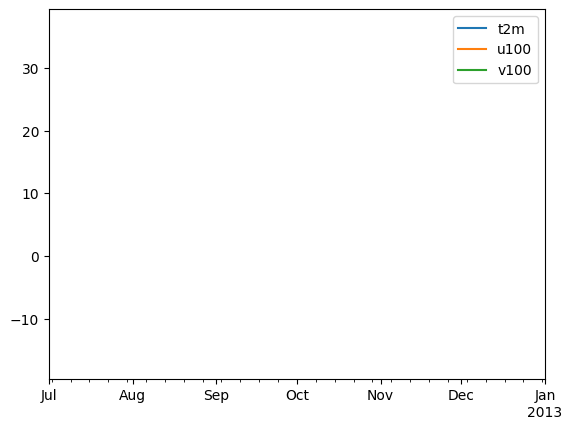

In [17]:
import pandas as pd
df = pd.read_csv("datasets/nrel_hrfcst.csv", index_col=0, parse_dates=True)[["power"]]
df.index = pd.date_range(start="2012-07-01 00:00:00", periods=len(df), freq="5min")
df_fcst = pd.read_csv("datasets/nrel_fcst.csv", index_col=0, parse_dates=True)
df["ds"] = df.index
df = df.join(df_fcst)
df = df.drop_duplicates(subset='ds')
df = df.drop(columns=["ds"])
print(df)
df.plot(y=["t2m","u100","v100"])

                         5min     15min     60min
ds                                               
2019-01-01 05:00:00  0.283403  0.284878  0.263034
2019-01-01 05:05:00  0.289713  0.278004  0.260037
2019-01-01 05:10:00  0.281517  0.271131  0.257039
2019-01-01 05:15:00  0.263150  0.264258  0.254041
2019-01-01 05:20:00  0.266563  0.259676  0.251044
...                       ...       ...       ...
2019-01-02 23:35:00  0.410300  0.414784       NaN
2019-01-02 23:40:00  0.407650  0.420249       NaN
2019-01-02 23:45:00  0.414833  0.425714       NaN
2019-01-02 23:50:00  0.429363       NaN       NaN
2019-01-02 23:55:00  0.432947       NaN       NaN

[516 rows x 3 columns]


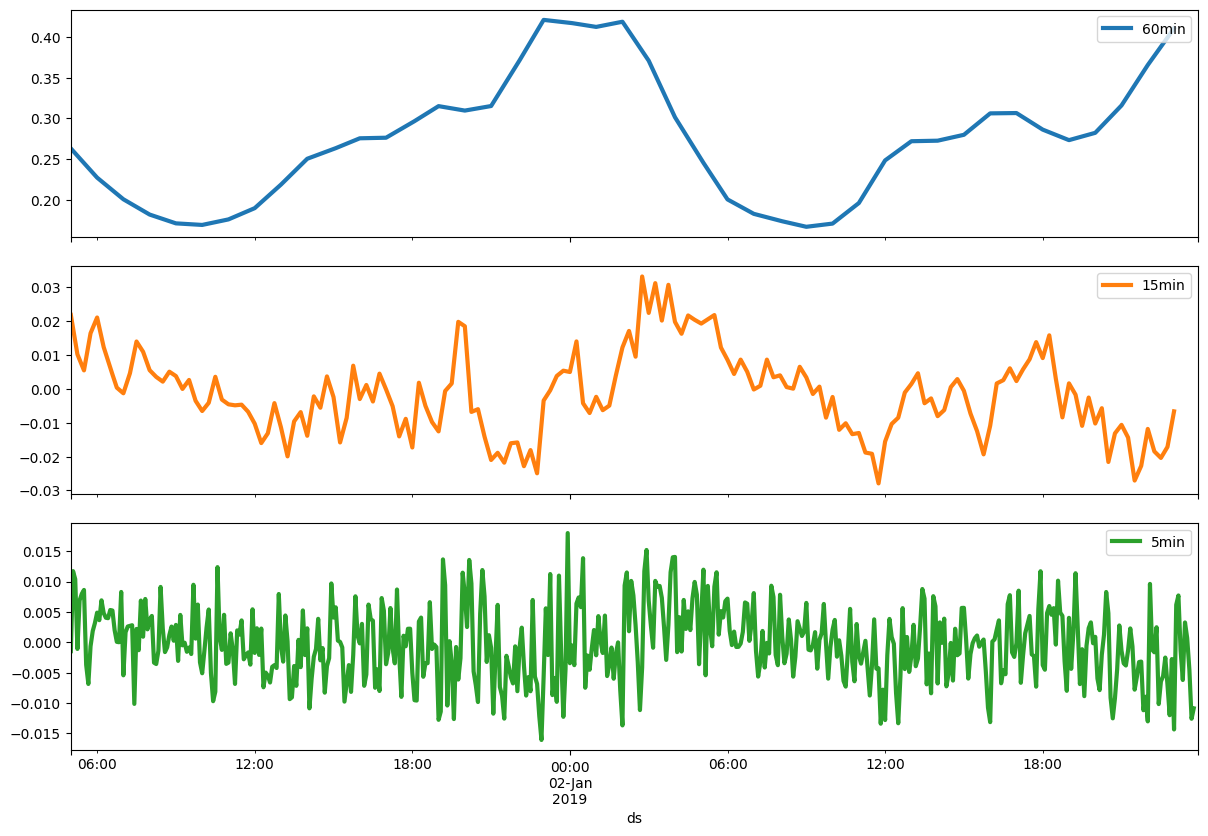

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("datasets/MFRED_wiztemp.csv",index_col=0, parse_dates=True)[["value"]]
# df = df.interpolate()
df = df["2019-01-01":"2019-01-02"]
fig, axs = plt.subplots(3, figsize=[12,8], sharex=True)
df_15min = df.resample("15min").mean()
df_15min = df_15min.resample("5min").mean().interpolate()
df_15min.columns=["15min"]
df_60min = df.resample("60min").mean()
df_60min = df_60min.resample("5min").mean().interpolate()
df_60min.columns=["60min"]
df.columns=["5min"]
df = pd.concat([df, df_15min,df_60min],axis=1)
print(df)
fig.tight_layout()

df["15res"] = df["15min"]-df["60min"]
df["5res"] = df["5min"]-df["15min"]
df.plot(y="5res", c="C2", label="5min", lw=3, ax=axs[2])
df.plot(y="15res", c="C1", label="15min", lw=3, ax=axs[1])
df.plot(y="60min",  c="C0", label="60min", lw=3, ax=axs[0])
for i in range(3):
    axs[i].legend(loc=1)

In [10]:
import pandas as pd
import numpy as np
df = pd.read_csv("datasets/nrel.csv", index_col=0, parse_dates=True)
ws = df[["wind_speed"]].resample("60min").mean()
temp = df[["temperature"]].resample("60min").mean()
# ws["ds"] = ws.index
ws = ws.reset_index(drop=True)
temp["ds"] = temp.index
temp = temp.reset_index(drop=True)
df["ds"] = df.index
df = df.reset_index(drop=True)
print(df)
print(pd.concat([ws, temp], axis=1))

merged_df = pd.merge(df[["ds","power"]], pd.concat([ws, temp], axis=1), on="ds", how="outer")
# merged_df = merged_df.dropna()
merged_df = merged_df.set_index("ds")
# merged_df = merged_df.dropna(subset=[select_site])
# df_5min
merged_df.to_csv("nrel_hrfcst.csv")

           power  wind_speed   density  temperature   pressure   
0       7.217024    7.870668  1.116202    297.55682  97627.490  \
1       7.199555    7.864600  1.116155    296.58975  97629.320   
2       7.225195    7.873760  1.116116    297.93216  97622.000   
3       7.140062    7.843310  1.116263    297.91733  97622.914   
4       6.840966    7.736583  1.116679    297.83795  97626.580   
...          ...         ...       ...          ...        ...   
52988  11.704662    9.142132  1.239315    271.46292  97919.590   
52989  11.456272    9.056694  1.239162    271.48734  97918.680   
52990  11.207892    8.971260  1.239006    271.50873  97915.016   
52991  11.153950    8.952937  1.238875    271.51483  97911.350   
52992  12.316486    9.374120  1.231153    273.75208  97874.730   

                             ds  
0     2012-07-01 00:00:00+00:00  
1     2012-07-01 00:05:00+00:00  
2     2012-07-01 00:10:00+00:00  
3     2012-07-01 00:15:00+00:00  
4     2012-07-01 00:20:00+00:00  
...

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("datasets/SOLETE_new_5min.csv", index_col=0, parse_dates=True)[["P_Solar[kW]"]]
df_fcst = pd.read_csv("datasets/solete_fcst.csv", index_col=0, parse_dates=True)
df_fcst["ssrd"] /= 3.6e6


start = 0
df_dhi = []
for i in range(len(df_fcst)//25):
    day_df = df_fcst.iloc[start:start+25, 1]
    # print(day_df)
    day_df = day_df.diff(-1).abs()
    # plt.plot(day_df)
    start+=25
    # print(day_df)
    df_dhi.append(day_df)
df_dhi = pd.concat(df_dhi)
df_dhi = df_dhi.dropna()

df_fcst["ds"] = df_fcst.index
df_fcst = df_fcst.drop_duplicates(subset='ds',keep="last")
df_fcst.drop(columns=["ds", "ssrd"],inplace=True)
df_fcst = df_fcst.join(df_dhi)
df = df.join(df_fcst)
df = df.iloc[:-1,:]
df.to_csv("datasets/solete_solar.csv")

# df = df.join(df_fcst)
# print(df.columns)
# df["ssrd"] /= 3.6e6
# df_diff= df["ssrd"].diff(1)
# print(df_diff[df_diff<0])
# plt.scatter(df_diff,df["GHI[kW1m2]"])
# df = df.drop(columns=df.columns[0])
# df["speed"] = np.sqrt(df["u100"]**2 + df["v100"]**2)
# df=df.interpolate()
# df.plot(kind="scatter", y="t2m", x="TEMPERATURE[degC]")
# df.to_csv("datasets/nrel_all.csv")

0.12458333333333328
0.14451666666666668
34.690396599902215
31.77376676827309


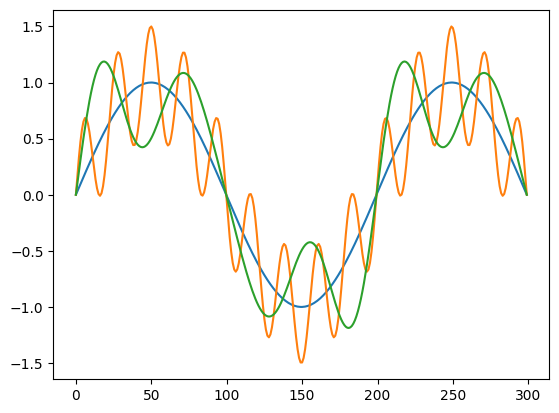

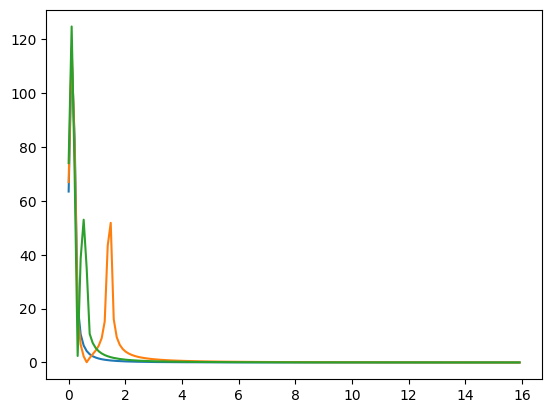

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

t = np.linspace(0, 3*np.pi, num=300)
y = np.sin(t)
y_pred = y + 0.5*np.sin(9*t)
y_pred_2 = y + 0.5*np.sin(3*t) + 0.2*np.sin(4*t)
fig = plt.figure()
plt.plot(y)
plt.plot(y_pred)
plt.plot(y_pred_2)
print(mean_squared_error(y, y_pred))
print(mean_squared_error(y, y_pred_2))
xf, yf = make_rfft(y, t.min(), t.max())
xpredf, ypredf = make_rfft(y_pred, t.min(), t.max())
xpred2f, ypred2f = make_rfft(y_pred_2, t.min(), t.max())
print(mean_squared_error(yf[None], ypredf[None]))
print(mean_squared_error(yf[None], ypred2f[None]))

fig = plt.figure()
plt.plot(xf, yf)
plt.plot(xpredf, ypredf)
plt.plot(xpred2f, ypred2f)
# plt.yscale("log")
# plt.xscale("log")

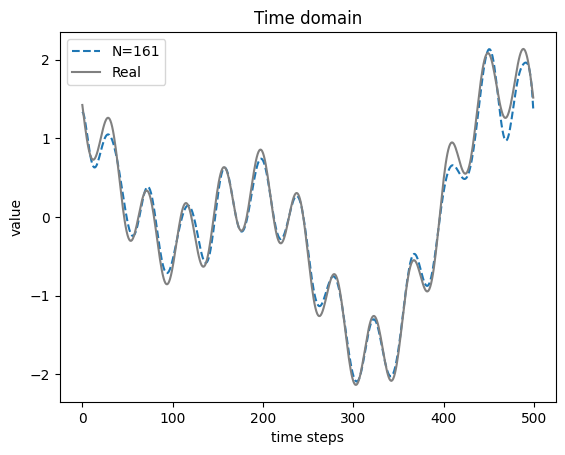

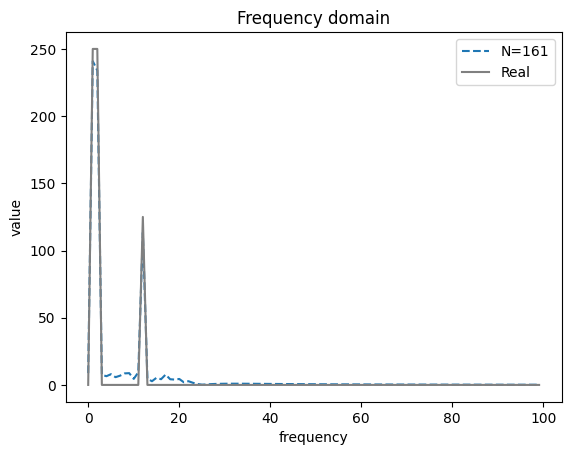

In [22]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pth = "results/sine/example_benchmarks-20230914-041044"
pth = "results/sine/example_benchmarks-20230914-042542"

model_names = ['Neural Laplace']
fcst_features = [0]
all_seed_result = []
all_seed_preds = []
for seed in range(1):
    with open(f"{pth}-{seed}.pkl", "rb") as f:
        all_result = pickle.load(f)
    test_result = {name: {} for name in model_names}
    test_preds_trajs = {name: {} for name in model_names}
    for avg_terms in all_result:
        result_avg = all_result[avg_terms]
        train_mean = result_avg['train_mean'][fcst_features]
        train_std = result_avg['train_std'][fcst_features]
        num_avg_terms = int(avg_terms.split("_")[-1])
        for name in model_names:
            model_results = result_avg[name]
            assert len(fcst_features) == model_results["test_preds"].shape[-1]
            test_preds = model_results["test_preds"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()
            test_trajs = model_results["test_trajs"] * train_std.cpu().numpy(
            ) + train_mean.cpu().numpy()

            fig, ax=plt.subplots()
            ax.plot(test_preds[0].squeeze(), ls="--",label="N=161")
            ax.plot(test_trajs[0].squeeze(),label="Real",c="grey")
            ax.legend()
            ax.set_ylabel("value")
            ax.set_xlabel("time steps")
            ax.set_title("Time domain")

            xf_test, yf_test = make_rfft(test_trajs[0].squeeze())
            xf_pred, yf_pred = make_rfft(test_preds[0].squeeze())
            fig, ax=plt.subplots()
            ax.plot(xf_pred[:100], yf_pred[:100],  ls="--",label="N=161")
            ax.plot(xf_test[:100], yf_test[:100],label="Real",c="grey")
            ax.legend()
            ax.set_ylabel("value")
            ax.set_xlabel("frequency")
            ax.set_title("Frequency domain")

            break
            pred_timesteps = test_trajs.shape[1]

            test_preds_trajs[name][num_avg_terms] = deepcopy(
                (test_preds, test_trajs))


